This is the aircraft gate assignment problem for the Operations optimization course. 

In [31]:
# Gurobi for optimization
from gurobipy import GRB, Model, quicksum
import gurobipy as gp

# Pandas for data manipulation
import pandas as pd

# Numpy for numerical operations
import numpy as np

# Matplotlib for visualization
import matplotlib.pyplot as plt

# Datetime for handling time-related data
import datetime

# Pickle for saving/loading objects (optional, based on need)
import pickle


In [32]:
# # Sample Data Generation
# num_flights = 100
# num_gates = 20

# # Seed for reproducibility
# np.random.seed(46)

# # Generate flight data
# flight_ids = [f"F{i+1}" for i in range(num_flights)]
# arrival_times = np.random.randint(0, 700, num_flights)  # minutes from midnight
# departure_times = arrival_times + np.random.randint(60, 180, num_flights)  # ensure at least 1 hour turnaround
# passenger_numbers = np.random.randint(50, 300, num_flights)
# flight_types = np.random.choice(['domestic', 'international'], num_flights)

# flight_data = pd.DataFrame({
#     'flight_id': flight_ids,
#     'arrival_time': arrival_times,
#     'departure_time': departure_times,
#     'passenger_number': passenger_numbers,
#     'flight_type': flight_types
# })

# # Generate gate data
# gate_ids = [f"G{i+1}" for i in range(num_gates)]
# gate_types = np.random.choice(['domestic', 'international'], num_gates)

# gate_data = pd.DataFrame({
#     'gate_id': gate_ids,
#     'gate_type': gate_types
# })

# # Calculate distances between gates (d_kl) and from gates to entrance/exit (ed_k)
# distances = np.random.randint(100, 1000, (num_gates, num_gates))
# np.fill_diagonal(distances, 0)
# distance_df = pd.DataFrame(distances, index=gate_ids, columns=gate_ids)
# ed_k = np.random.randint(100, 500, num_gates)

# # Generate transiting passengers data (p_ij) with constraints
# p_ij = np.zeros((num_flights, num_flights), dtype=int)

# for i in range(num_flights):
#     max_transit_passengers = passenger_numbers[i] // 2  # Maximum of 50% of the total passengers
#     remaining_passengers = max_transit_passengers
#     transfer_flights = np.random.choice([x for x in range(num_flights) if x != i], 2, replace=False)  # Choose 2 different flights
#     for j in transfer_flights:
#         if remaining_passengers > 0:
#             p_ij[i, j] = np.random.randint(0, min(50, remaining_passengers + 1))
#             remaining_passengers -= p_ij[i, j]

# # Verify generated data
# print("Flight Data:")
# print(flight_data.head(num_flights))

# print("\nGate Data:")
# print(gate_data.head(num_gates))

# print("\nDistance Matrix (d_kl):")
# print(distance_df)

# print("\nDistance to Entrance/Exit (ed_k):")
# print(pd.Series(ed_k, index=gate_ids))

# print("\nTransiting Passengers (p_ij):")
# print(pd.DataFrame(p_ij, index=flight_ids, columns=flight_ids).head())

In [47]:
##SMALL DATASET 10 FLIGHTS 5 GATES

# # Seed for reproducibility
np.random.seed(46)

# Generate smaller flight data
flight_ids = [f"F{i:02d}" for i in range(1, 11)]
arrival_times = ['09:00', '08:30', '09:00', '08:30', '08:15',
                 '07:30', '10:15', '10:00', '10:25', '10:40']
departure_times = ['09:50', '09:10', '09:50', '10:20', '09:00',
                   '08:50', '11:20', '10:50', '11:55', '11:35']
passenger_numbers = [140, 138, 340, 293, 252,
                     105, 130, 166, 191, 178]
flight_types = ['Domestic', 'Domestic', 'International', 'International', 'International',
                'Domestic', 'Domestic', 'Domestic', 'International', 'Domestic']

# Convert times to minutes since midnight for consistency with previous code
def time_to_minutes(t):
    h, m = map(int, t.split(':'))
    return h * 60 + m

arrival_times = [time_to_minutes(t) for t in arrival_times]
departure_times = [time_to_minutes(t) for t in departure_times]

flight_data = pd.DataFrame({
    'flight_id': flight_ids,
    'arrival_time': arrival_times,
    'departure_time': departure_times,
    'passenger_number': passenger_numbers,
    'flight_type': flight_types
})

# Generate smaller gate data
gate_ids = [f"Gate {i}" for i in range(1, 6)]
gate_types = ['Domestic', 'Domestic', 'International', 'International', 'Domestic']

gate_data = pd.DataFrame({
    'gate_id': gate_ids,
    'gate_type': gate_types
})

# Calculate distances between gates (d_kl) and from gates to entrance/exit (ed_k)
distances = [
    [0, 2, 4, 6, 8],
    [2, 0, 2, 4, 6],
    [4, 2, 0, 2, 4],
    [6, 4, 2, 0, 2],
    [8, 6, 4, 2, 0]
]

distance_df = pd.DataFrame(distances, index=gate_ids, columns=gate_ids)
ed_k = [5, 3, 3, 5, 7]

# Store number of flights and gates
num_flights = len(flight_data)
num_gates = len(gate_data)

# Generate transiting passengers data (p_ij) with constraints
p_ij = np.zeros((num_flights, num_flights), dtype=int)

for i in range(num_flights):
    max_transit_passengers = passenger_numbers[i] // 2  # Maximum of 50% of the total passengers
    remaining_passengers = max_transit_passengers
    transfer_flights = np.random.choice([x for x in range(num_flights) if x != i], 2, replace=False)  # Choose 2 different flights
    for j in transfer_flights:
        if remaining_passengers > 0:
            p_ij[i, j] = np.random.randint(0, min(50, remaining_passengers + 1))
            remaining_passengers -= p_ij[i, j]

# Verify generated data
print("Flight Data:")
print(flight_data.head(num_flights))

print("\nGate Data:")
print(gate_data.head(num_gates))

print("\nDistance Matrix (d_kl):")
print(distance_df)

print("\nDistance to Entrance/Exit (ed_k):")
print(pd.Series(ed_k, index=gate_ids))

print("\nTransiting Passengers (p_ij):")
print(pd.DataFrame(p_ij, index=flight_ids, columns=flight_ids).head(num_flights))


Flight Data:
  flight_id  arrival_time  departure_time  passenger_number    flight_type
0       F01           540             590               140       Domestic
1       F02           510             550               138       Domestic
2       F03           540             590               340  International
3       F04           510             620               293  International
4       F05           495             540               252  International
5       F06           450             530               105       Domestic
6       F07           615             680               130       Domestic
7       F08           600             650               166       Domestic
8       F09           625             715               191  International
9       F10           640             695               178       Domestic

Gate Data:
  gate_id      gate_type
0  Gate 1       Domestic
1  Gate 2       Domestic
2  Gate 3  International
3  Gate 4  International
4  Gate 5       Domestic


In [34]:
# Generate flight data
flight_ids = [f"F{i:02d}" for i in range(1, 26)]
arrival_times = ['09:00', '08:30', '09:00', '08:30', '08:15',
                 '07:30', '10:15', '10:00', '10:25', '10:40',
                 '11:00', '11:00', '11:15', '11:30', '11:30',
                 '12:00', '11:45', '11:50', '11:55', '12:10',
                 '12:45', '12:05', '12:10', '12:20', '12:20']
departure_times = ['09:50', '09:10', '09:50', '10:20', '09:00',
                   '08:50', '11:20', '10:50', '11:55', '11:35',
                   '12:35', '12:25', '12:15', '12:20', '12:40',
                   '13:55', '13:40', '12:45', '12:55', '14:00',
                   '14:30', '13:00', '13:30', '13:20', '13:40']
passenger_numbers = [140, 138, 340, 293, 252,
                     105, 130, 166, 191, 178,
                     293, 166, 255, 183, 176,
                     220, 173, 145, 118, 153,
                     256, 104, 269, 140, 142]
flight_types = ['Domestic', 'Domestic', 'International', 'International', 'International',
                'Domestic', 'Domestic', 'Domestic', 'International', 'Domestic',
                'International', 'Domestic', 'International', 'International', 'Domestic',
                'International', 'Domestic', 'Domestic', 'Domestic', 'Domestic',
                'International', 'Domestic', 'International', 'Domestic', 'Domestic']

# Convert times to minutes since midnight for consistency with previous code
def time_to_minutes(t):
    h, m = map(int, t.split(':'))
    return h * 60 + m

arrival_times = [time_to_minutes(t) for t in arrival_times]
departure_times = [time_to_minutes(t) for t in departure_times]

flight_data = pd.DataFrame({
    'flight_id': flight_ids,
    'arrival_time': arrival_times,
    'departure_time': departure_times,
    'passenger_number': passenger_numbers,
    'flight_type': flight_types
})

# Generate gate data
gate_ids = [f"Gate {i}" for i in range(1, 7)]
gate_types = ['Domestic', 'Domestic', 'Domestic', 'International', 'International', 'International']

gate_data = pd.DataFrame({
    'gate_id': gate_ids,
    'gate_type': gate_types
})

# Calculate distances between gates (d_kl) and from gates to entrance/exit (ed_k)
distances = [
    [0, 2, 4, 6, 8, 10],
    [2, 0, 2, 4, 6, 8],
    [4, 2, 0, 2, 4, 6],
    [6, 4, 2, 0, 2, 4],
    [8, 6, 4, 2, 0, 2],
    [10, 8, 6, 4, 2, 0]
]

distance_df = pd.DataFrame(distances, index=gate_ids, columns=gate_ids)
ed_k = [3, 5, 7, 9, 11, 13]

# Store number of flights and gates
num_flights = len(flight_data)
num_gates = len(gate_data)

# Generate transiting passengers data (p_ij) with constraints
p_ij = np.zeros((num_flights, num_flights), dtype=int)

for i in range(num_flights):
    max_transit_passengers = passenger_numbers[i] // 2  # Maximum of 50% of the total passengers
    remaining_passengers = max_transit_passengers
    transfer_flights = np.random.choice([x for x in range(num_flights) if x != i], 2, replace=False)  # Choose 2 different flights
    for j in transfer_flights:
        if remaining_passengers > 0:
            p_ij[i, j] = np.random.randint(0, min(50, remaining_passengers + 1))
            remaining_passengers -= p_ij[i, j]

# Verify generated data
print("Flight Data:")
print(flight_data.head(num_flights))

print("\nGate Data:")
print(gate_data.head(num_gates))

print("\nDistance Matrix (d_kl):")
print(distance_df)

print("\nDistance to Entrance/Exit (ed_k):")
print(pd.Series(ed_k, index=gate_ids))

print("\nTransiting Passengers (p_ij):")
print(pd.DataFrame(p_ij, index=flight_ids, columns=flight_ids).head(num_flights))


Flight Data:
   flight_id  arrival_time  departure_time  passenger_number    flight_type
0        F01           540             590               140       Domestic
1        F02           510             550               138       Domestic
2        F03           540             590               340  International
3        F04           510             620               293  International
4        F05           495             540               252  International
5        F06           450             530               105       Domestic
6        F07           615             680               130       Domestic
7        F08           600             650               166       Domestic
8        F09           625             715               191  International
9        F10           640             695               178       Domestic
10       F11           660             755               293  International
11       F12           660             745               166       Domestic

In [35]:
# Generate flight data
flight_ids = [f"F{i:02d}" for i in range(1, 51)]
arrival_times = ['09:00', '08:30', '09:00', '08:30', '08:15',
                     '07:30', '10:15', '10:00', '10:25', '10:40',
                     '11:00', '11:00', '11:15', '11:30', '11:30',
                     '12:00', '11:45', '11:50', '11:55', '12:10',
                     '12:45', '12:05', '12:10', '12:20', '12:20',
                     '12:20', '12:30', '12:25', '12:40', '12:55',
                     '12:50', '12:00', '13:00', '13:10', '14:25',
                     '14:30', '14:00', '14:55', '15:00', '19:55',
                     '18:30', '19:30', '18:55', '21:00', '20:10',
                     '20:00', '22:30', '21:25', '21:30', '22:15']
departure_times = ['09:50', '09:10', '09:50', '10:20', '09:00',
                       '08:50', '11:20', '10:50', '11:55', '11:35',
                       '12:35', '12:25', '12:15', '12:20', '12:40',
                       '13:55', '13:40', '12:45', '12:55', '14:00',
                       '14:30', '13:00', '13:30', '13:20', '13:40',
                       '13:30', '14:10', '14:10', '14:40', '13:40',
                       '14:30', '12:55', '14:25', '14:45', '16:10',
                       '15:20', '15:20', '16:00', '15:50', '21:25',
                       '19:25', '20:50', '19:55', '22:55', '22:00',
                       '21:15', '23:25', '23:15', '22:45', '23:10']
passenger_numbers = [140, 138, 340, 293, 252,
                         105, 130, 166, 191, 178,
                         293, 166, 255, 183, 176,
                         220, 173, 145, 118, 153,
                         256, 104, 269, 140, 142,
                         129, 190, 142, 163, 185,
                         258, 133, 156, 120, 193,
                         300, 104, 219, 239, 111,
                         166, 242, 167, 278, 195,
                         144, 219, 253, 158, 276]
flight_types = ['Domestic', 'Domestic', 'International', 'International', 'International',
                    'Domestic', 'Domestic', 'Domestic', 'International', 'Domestic',
                    'International', 'Domestic', 'International', 'International', 'Domestic',
                    'International', 'Domestic', 'Domestic', 'Domestic', 'Domestic',
                    'International', 'Domestic', 'International', 'Domestic', 'Domestic',
                    'Domestic', 'International', 'Domestic', 'Domestic', 'International',
                    'International', 'Domestic', 'Domestic', 'Domestic', 'International',
                    'International', 'Domestic', 'International', 'International', 'Domestic',
                    'Domestic', 'International', 'Domestic', 'International', 'International',
                    'Domestic', 'International', 'International', 'Domestic', 'International']

# Convert times to minutes since midnight for consistency with previous code
def time_to_minutes(t):
    h, m = map(int, t.split(':'))
    return h * 60 + m

arrival_times = [time_to_minutes(t) for t in arrival_times]
departure_times = [time_to_minutes(t) for t in departure_times]

flight_data = pd.DataFrame({
    'flight_id': flight_ids,
    'arrival_time': arrival_times,
    'departure_time': departure_times,
    'passenger_number': passenger_numbers,
    'flight_type': flight_types
})

# Generate gate data
gate_ids = [f"Gate {i}" for i in range(1, 11)]
gate_types = ['Domestic', 'Domestic', 'Domestic', 'Domestic', 'Domestic',
                  'International', 'International', 'International', 'International', 'International']

gate_data = pd.DataFrame({
    'gate_id': gate_ids,
    'gate_type': gate_types
})

# Calculate distances between gates (d_kl) and from gates to entrance/exit (ed_k)
distances = [
    [0, 2, 4, 6, 8, 4, 6, 8, 10, 12],
    [2, 0, 2, 4, 6, 6, 8, 10, 12, 14],
    [4, 2, 0, 2, 4, 8, 10, 12, 14, 16],
    [6, 4, 2, 0, 2, 10, 12, 14, 16, 18],
    [8, 6, 4, 2, 0, 12, 14, 16, 18, 20],
    [4, 6, 8, 10, 12, 0, 2, 4, 6, 8],
    [6, 8, 10, 12, 14, 2, 0, 2, 4, 6],
    [8, 10, 12, 14, 16, 4, 2, 0, 2, 4],
    [10, 12, 14, 16, 18, 6, 4, 2, 0, 2],
    [12, 14, 16, 18, 20, 8, 6, 4, 2, 0]
]

distance_df = pd.DataFrame(distances, index=gate_ids, columns=gate_ids)
ed_k = [3, 5, 7, 9, 11, 3, 5, 7, 9, 11]

#store number of flights and gates
num_flights= len(flight_data)
num_gates =len(gate_data)

# Generate transiting passengers data (p_ij) with constraints
p_ij = np.zeros((num_flights, num_flights), dtype=int)

for i in range(num_flights):
    max_transit_passengers = passenger_numbers[i] // 2  # Maximum of 50% of the total passengers
    remaining_passengers = max_transit_passengers
    for j in np.random.permutation(num_flights):  # Randomly permute to distribute passengers
        if i != j and remaining_passengers > 0:
            p_ij[i, j] = np.random.randint(0, min(50, remaining_passengers + 1))
            remaining_passengers -= p_ij[i, j]


# Verify generated data
print("Flight Data:")
print(flight_data.head(num_flights))

print("\nGate Data:")
print(gate_data.head(num_gates+1))

print("\nDistance Matrix (d_kl):")
print(distance_df)

print("\nDistance to Entrance/Exit (ed_k):")
print(pd.Series(ed_k, index=gate_ids))

print("\nTransiting Passengers (p_ij):")
print(pd.DataFrame(p_ij, index=flight_ids, columns=flight_ids).head(num_flights))


Flight Data:
   flight_id  arrival_time  departure_time  passenger_number    flight_type
0        F01           540             590               140       Domestic
1        F02           510             550               138       Domestic
2        F03           540             590               340  International
3        F04           510             620               293  International
4        F05           495             540               252  International
5        F06           450             530               105       Domestic
6        F07           615             680               130       Domestic
7        F08           600             650               166       Domestic
8        F09           625             715               191  International
9        F10           640             695               178       Domestic
10       F11           660             755               293  International
11       F12           660             745               166       Domestic

### Model Explanation

The objective of the FC formulation is to minimize the total walking distance of passengers at the airport, considering both transfer passengers and non-transfer passengers. The model includes the following key components:

- **Parameters**:
  - `num_flights`: Number of flights
  - `num_gates`: Number of gates
  - `arrival_times`: Arrival times of flights
  - `departure_times`: Departure times of flights
  - `passenger_numbers`: Number of passengers per flight
  - `flight_types`: Type of flight (domestic/international)
  - `gate_types`: Type of gate (domestic/international)
  - `distances`: Distance matrix between gates

- **Decision Variables**:
  - `x[i, k]`: Binary variable, 1 if flight \(i\) is assigned to gate \(k\), 0 otherwise
  - `w[i, k, l]`: Continuous variable representing the number of passengers from flight \(i\) through gate \(k\) to gate \(l\)

- **Objective Function**:
  - Minimize the total walking distance of passengers.

- **Constraints**:
  - Each flight must be assigned to exactly one gate.
  - Gates cannot be double-booked.
  - Flow balance constraints for transfer passengers.


In [48]:
# Initialize the Gurobi model
model = Model("FC_Formulation")

# Distance penalty for the apron
apron_distance_penalty = 30

# Distance matrices
d_kl = np.zeros((num_gates + 1, num_gates + 1))
d_kl[:num_gates, :num_gates] = distance_df.values
d_kl[num_gates, :] = apron_distance_penalty  # Distance from apron to all gates
d_kl[:, num_gates] = apron_distance_penalty  # Distance from all gates to apron
d_kl[num_gates, num_gates] = apron_distance_penalty  # Distance from apron to itself

# Distance to/from exit for each gate (including apron)
ed_k = np.append(ed_k, apron_distance_penalty)  # Append apron distance to exit

print(d_kl,ed_k)
# Passengers data
e_i = flight_data['passenger_number'].values - np.sum(p_ij, axis=1)
f_i = flight_data['passenger_number'].values - np.sum(p_ij, axis=0)

# Aircraft type (domestic/international)
g_i = flight_data['flight_type'].apply(lambda x: 'D' if x == 'Domestic' else 'I').values

# Sets of domestic and international gates
K_D = [k for k, t in zip(range(num_gates), gate_types) if t == 'Domestic']
K_I = [k for k, t in zip(range(num_gates), gate_types) if t == 'International']
K_D.append(num_gates)  # Add apron to domestic gates
K_I.append(num_gates)  # Add apron to international gates

# Number of gates
m = num_gates

# Generating overlap sets for all time steps
def generate_overlap_sets(flight_data):
    # Initialize dictionaries to hold overlap sets
    I_Dt = []
    I_It = []
    T_D = {}
    T_I = {}
    
    # Iterate through each minute of the day
    for t in range(1440):
        domestic_overlaps = set()
        international_overlaps = set()
        
        # Check for overlapping flights at time t
        for i, flight in flight_data.iterrows():
            if flight['arrival_time'] <= t < flight['departure_time']:
                if flight['flight_type'] == 'Domestic':
                    domestic_overlaps.add(flight['flight_id'])
                else:
                    international_overlaps.add(flight['flight_id'])
        
        if domestic_overlaps:
            I_Dt.append(domestic_overlaps)
        if international_overlaps:
            I_It.append(international_overlaps)
    
    # Convert I_Dt and I_It to T_D and T_I
    for idx, overlap_set in enumerate(I_Dt):
        if overlap_set:
            T_D[f"TD{idx+1}"] = overlap_set
            
    for idx, overlap_set in enumerate(I_It):
        if overlap_set:
            T_I[f"TI{idx+1}"] = overlap_set
    
    return T_D, T_I

# Generate overlap sets
T_D, T_I = generate_overlap_sets(flight_data)

# Print overlap sets
print("Overlap Sets for Domestic Flights (T_D):")
for key, value in T_D.items():
    print(f"{key}: {value}")

print("\nOverlap Sets for International Flights (T_I):")
for key, value in T_I.items():
    print(f"{key}: {value}")

# Calculate N_A_star
def calculate_N_A_star(T_D, T_I, K_D, K_I):
    N_A_star = 0
    for overlap_set in T_D.values():
        if len(overlap_set) > len(K_D):
            N_A_star += len(overlap_set) - len(K_D) + 1
            print(f"Domestic Overlap Set: {overlap_set}, Excess: {len(overlap_set) - len(K_D)+1}")
    for overlap_set in T_I.values():
        if len(overlap_set) > len(K_I):
            N_A_star += len(overlap_set) - len(K_I) + 1
            print(f"International Overlap Set: {overlap_set}, Excess: {len(overlap_set) - len(K_I)+1}")
    return N_A_star

N_A_star = calculate_N_A_star(T_D, T_I, K_D, K_I)
print("\nN_A_star:", N_A_star)

# Define function to calculate NA*
def calculate_NA_star(flight_data, num_gates):
    # Create a list to hold the number of aircraft at each minute
    time_slots = [0] * 1440  # There are 1440 minutes in a day

    # Populate the list with the number of overlapping aircraft at each minute
    for index, flight in flight_data.iterrows():
        for t in range(flight['arrival_time'], flight['departure_time']):
            time_slots[t] += 1
    
    # Calculate the maximum number of aircraft exceeding the available gates
    max_excess_aircraft = max([max(0, count - num_gates) for count in time_slots])
    
    return max_excess_aircraft

NA_star = calculate_NA_star(flight_data, num_gates)
print("NA*:", NA_star)

# Decision Variables
x = model.addVars(num_flights, num_gates + 1, vtype=GRB.BINARY, name="x")
w = model.addVars(num_flights, num_gates + 1, num_gates + 1, vtype=GRB.CONTINUOUS, name="w")

# Verify variables
print("Decision variables defined.")


[[ 0.  2.  4.  6.  8. 30.]
 [ 2.  0.  2.  4.  6. 30.]
 [ 4.  2.  0.  2.  4. 30.]
 [ 6.  4.  2.  0.  2. 30.]
 [ 8.  6.  4.  2.  0. 30.]
 [30. 30. 30. 30. 30. 30.]] [ 5  3  3  5  7 30]
Overlap Sets for Domestic Flights (T_D):
TD1: {'F06'}
TD2: {'F06'}
TD3: {'F06'}
TD4: {'F06'}
TD5: {'F06'}
TD6: {'F06'}
TD7: {'F06'}
TD8: {'F06'}
TD9: {'F06'}
TD10: {'F06'}
TD11: {'F06'}
TD12: {'F06'}
TD13: {'F06'}
TD14: {'F06'}
TD15: {'F06'}
TD16: {'F06'}
TD17: {'F06'}
TD18: {'F06'}
TD19: {'F06'}
TD20: {'F06'}
TD21: {'F06'}
TD22: {'F06'}
TD23: {'F06'}
TD24: {'F06'}
TD25: {'F06'}
TD26: {'F06'}
TD27: {'F06'}
TD28: {'F06'}
TD29: {'F06'}
TD30: {'F06'}
TD31: {'F06'}
TD32: {'F06'}
TD33: {'F06'}
TD34: {'F06'}
TD35: {'F06'}
TD36: {'F06'}
TD37: {'F06'}
TD38: {'F06'}
TD39: {'F06'}
TD40: {'F06'}
TD41: {'F06'}
TD42: {'F06'}
TD43: {'F06'}
TD44: {'F06'}
TD45: {'F06'}
TD46: {'F06'}
TD47: {'F06'}
TD48: {'F06'}
TD49: {'F06'}
TD50: {'F06'}
TD51: {'F06'}
TD52: {'F06'}
TD53: {'F06'}
TD54: {'F06'}
TD55: {'F06'}
TD56: {'F06'}
T

In [49]:
# Objective function components\n",
objective = quicksum(d_kl[k, l] * w[i, k, l] for i in range(num_flights) for k in range(num_gates + 1) for l in range(num_gates + 1)) + \
            quicksum((e_i[i] + f_i[i]) * ed_k[k] * x[i, k] for i in range(num_flights) for k in range(num_gates + 1))

model.setObjective(objective, GRB.MINIMIZE)

# Verify objective
print("Objective function defined.")

Objective function defined.


In [50]:
# Constraint 3: Assign each aircraft to exactly one gate
for i in range(num_flights):
    if g_i[i] == 'D':
        model.addConstr(quicksum(x[i, k] for k in K_D) == 1, name=f"Assign_Domestic_{i}")
    else:
        model.addConstr(quicksum(x[i, k] for k in K_I) == 1, name=f"Assign_International_{i}")

# Add Constraints (4) and (5): At most one aircraft can be assigned to a fixed gate during a certain time interval
# Constraint (4) for domestic flights (excluding apron)
for t, I_Dt in T_D.items():
    for k in K_D[:-1]:  # Exclude the apron
        model.addConstr(quicksum(x[flight_ids.index(flight), k] for flight in I_Dt) <= 1, name=f"MaxOneAircraft_Domestic_{t}_Gate{k}")

# Constraint (5) for international flights (excluding apron)
for t, I_It in T_I.items():
    for k in K_I[:-1]:  # Exclude the apron
        model.addConstr(quicksum(x[flight_ids.index(flight), k] for flight in I_It) <= 1, name=f"MaxOneAircraft_International_{t}_Gate{k}")

# # Constraint 6: Minimum apron assignments
# model.addConstr(quicksum(x[i, num_gates] for i in range(num_flights)) <= 5, name="min_apron_assignments")

# Constraint (10): Passenger flow balance constraints (outbound)
for i in range(num_flights):
    gate_set = K_D if g_i[i] == 'D' else K_I  # Select the appropriate gate set
    for k in gate_set:
        model.addConstr(
            quicksum(w[i, k, l] for l in range(num_gates + 1)) == x[i, k] * sum(p_ij[i, j] for j in range(num_flights)),
            name=f"FlowBalance_{i}_{k}"
        )

# Constraint 11: Passenger flow balance constraints (inbound)
for i in range(num_flights):
    gate_set = K_D if g_i[i] == 'D' else K_I  # Select the appropriate gate set
    for k in range(num_gates + 1):  # Iterate over all gates including the apron
        model.addConstr(
            quicksum(w[i, l, k] for l in gate_set) == 
            quicksum(p_ij[i, j] * x[j, k] for j in range(num_flights)),
            name=f"PassengerFlow_{i}_{k}"
        )

# Constraint 12: Non-negativity of flow variables
for i in range(num_flights):
    gate_set = K_D if g_i[i] == 'D' else K_I  # Select the appropriate gate set
    for k in gate_set:
        for l in range(num_gates + 1):  # Iterate over all gates including the apron
            model.addConstr(
                w[i, k, l] >= 0,
                name=f"NonNegativeFlow_{i}_{k}_{l}"
            )

# Constraint (13): Ensure that overlapping domestic aircraft are assigned to the apron
for t, I_Dt in T_D.items():
    if len(I_Dt) > len(K_D) - 1:  # K_D includes the apron, so len(K_D) - 1 is the number of fixed gates
        model.addConstr(
            quicksum(x[flight_ids.index(flight), num_gates] for flight in I_Dt) >= len(I_Dt) - (len(K_D) - 1),
            name=f"ApronAssignment_Domestic_{t}"
        )

# Constraint (14): Ensure that overlapping international aircraft are assigned to the apron
for t, I_It in T_I.items():
    if len(I_It) > len(K_I) - 1:  # K_I includes the apron, so len(K_I) - 1 is the number of fixed gates
        model.addConstr(
            quicksum(x[flight_ids.index(flight), num_gates] for flight in I_It) >= len(I_It) - (len(K_I) - 1),
            name=f"ApronAssignment_International_{t}"
        )

# Verify constraints
print("Constraints defined.")


Constraints defined.


In [54]:
# Optimize model
model.optimize()

# Print results
if model.status == GRB.OPTIMAL:
    # Print flight assignments to gates
    for i in range(num_flights):
        for k in range(num_gates + 1):
            if x[i, k].X > 0.5:  # Check if the flight is assigned to the gate
                gate = 'Apron' if k == num_gates else gate_ids[k]
                print(f"Flight {flight_data.loc[i, 'flight_id']} is assigned to {gate}")
    
    # Print the flow of passengers between gates and to the exit
    print("\nPassenger Flow Between Gates and to the Exit:")
    for i in range(num_flights):
        for k in range(num_gates + 1):
            gate_from = 'Apron' if k == num_gates else gate_ids[k]
            total_transfer_passengers = 0
            # Flow to other gates
            for l in range(num_gates + 1):
                if w[i, k, l].X > 0:  # Only print non-zero flows
                    gate_to = 'Apron' if l == num_gates else gate_ids[l]
                    print(f"Flow from Flight {flight_data.loc[i, 'flight_id']} at {gate_from} to {gate_to}: {w[i, k, l].X}")
                    total_transfer_passengers += w[i, k, l].X
            # Flow to exit
            if x[i, k].X > 0.5:
                passengers_to_exit = flight_data.loc[i, 'passenger_number'] - total_transfer_passengers
                if passengers_to_exit > 0:
                    print(f"Flow from Flight {flight_data.loc[i, 'flight_id']} at {gate_from} to Exit: {passengers_to_exit}")
else:
    print("No optimal solution found.")


Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (win64 - Windows 11+.0 (22631.2))

CPU model: Intel(R) Core(TM) i7-8750H CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 1457 rows, 420 columns and 2444 nonzeros
Model fingerprint: 0x61f17fe0
Variable types: 360 continuous, 60 integer (60 binary)
Coefficient statistics:
  Matrix range     [1e+00, 5e+01]
  Objective range  [2e+00, 2e+04]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolved: 113 rows, 266 columns, 639 nonzeros

Continuing optimization...


Explored 1 nodes (50 simplex iterations) in 0.01 seconds (0.00 work units)
Thread count was 12 (of 12 available processors)

Solution count 5: 13262 28095 44482 ... 68588

Optimal solution found (tolerance 1.00e-04)
Best objective 1.326200000000e+04, best bound 1.326200000000e+04, gap 0.0000%
Flight F01 is assigned to Gate 2
Flight F02 is assigned to Gate 1
Flight 

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (win64 - Windows 11+.0 (22631.2))

CPU model: Intel(R) Core(TM) i7-8750H CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 1457 rows, 420 columns and 2444 nonzeros
Model fingerprint: 0x61f17fe0
Variable types: 360 continuous, 60 integer (60 binary)
Coefficient statistics:
  Matrix range     [1e+00, 5e+01]
  Objective range  [2e+00, 2e+04]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolved: 113 rows, 266 columns, 639 nonzeros

Continuing optimization...


Explored 1 nodes (50 simplex iterations) in 0.01 seconds (0.00 work units)
Thread count was 12 (of 12 available processors)

Solution count 5: 13262 28095 44482 ... 68588

Optimal solution found (tolerance 1.00e-04)
Best objective 1.326200000000e+04, best bound 1.326200000000e+04, gap 0.0000%


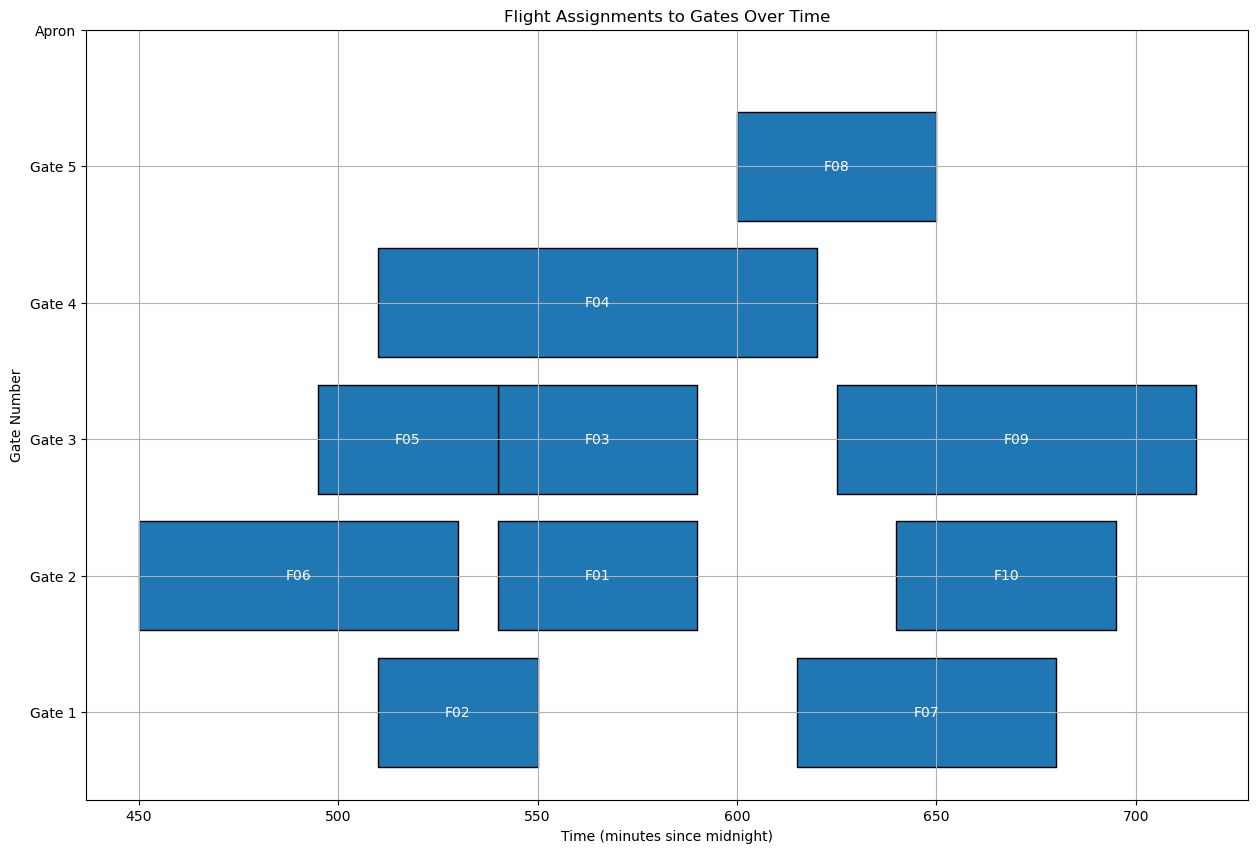

In [55]:
# Optimize model
model.optimize()

# Create a dictionary to store flight assignments
flight_assignments = {}

# Collect flight assignments to gates
if model.status == GRB.OPTIMAL:
    for i in range(num_flights):
        for k in range(num_gates + 1):
            if x[i, k].X > 0.5:  # Check if the flight is assigned to the gate
                gate = 'Apron' if k == num_gates else gate_ids[k]
                flight_assignments[flight_data.loc[i, 'flight_id']] = {
                    'gate': gate,
                    'arrival_time': flight_data.loc[i, 'arrival_time'],
                    'departure_time': flight_data.loc[i, 'departure_time']
                }

    # Plot the flight assignments
    fig, ax = plt.subplots(figsize=(15, 10))

    for flight_id, info in flight_assignments.items():
        gate = info['gate']
        arrival_time = info['arrival_time']
        departure_time = info['departure_time']
        gate_num = gate_ids.index(gate) + 1 if gate != 'Apron' else num_gates + 1

        ax.broken_barh([(arrival_time, departure_time - arrival_time)], (gate_num - 0.4, 0.8),
                       facecolors=('tab:blue'), edgecolors=('black'))
        ax.text((arrival_time + departure_time) / 2, gate_num, flight_id,
                ha='center', va='center', color='white')

    # Set labels and title
    ax.set_xlabel('Time (minutes since midnight)')
    ax.set_ylabel('Gate Number')
    ax.set_title('Flight Assignments to Gates Over Time')
    ax.set_yticks(range(1, num_gates + 2))
    ax.set_yticklabels(gate_ids + ['Apron'])
    ax.grid(True)

    plt.show()
else:
    print("No optimal solution found.")


In [61]:
# Gates and distances (you may already have this part)

distance_to_exit = ed_k  # Distance from each gate to the exit
distance_to_entrance = ed_k  # Distance from the entrance to each gate

# Passenger data (already given)
flight_assignments = {
    "F01": 2, "F02": 1, "F03": 3, "F04": 4, "F05": 3,
    "F06": 2, "F07": 1, "F08": 5, "F09": 3, "F10": 2
}

# Calculate walking distances
total_walking_distance = 0
total_transfer_distance = 0

for i in range(len(flight_assignments)):
    flight_id = f"F{i+1:02d}"
    gate_idx = flight_assignments[flight_id] - 1  # Gate index
    inflow_passengers = passenger_numbers[i] - sum(p_ij[i])
    outflow_passengers = passenger_numbers[i] - sum([p_ij[j][i] for j in range(len(p_ij))])
    
    print(f"Flight: {flight_id} at Gate {gate_idx + 1}")
    print(f"  Inflow Passengers: {inflow_passengers}")
    print(f"  Outflow Passengers: {outflow_passengers}")
    
    # Distance for inflow passengers
    inflow_distance = inflow_passengers * distance_to_entrance[gate_idx]
    total_walking_distance += inflow_distance
    print(f"  Inflow Distance: {inflow_distance} (inflow_passengers * distance_to_entrance[{gate_idx}])")
    
    # Distance for outflow passengers
    outflow_distance = outflow_passengers * distance_to_exit[gate_idx]
    total_walking_distance += outflow_distance
    print(f"  Outflow Distance: {outflow_distance} (outflow_passengers * distance_to_exit[{gate_idx}])")
    
    # Distance for transfer passengers
    for j in range(len(flight_assignments)):
        if p_ij[i][j] > 0:
            transfer_gate_idx = flight_assignments[f"F{j+1:02d}"] - 1
            transfer_distance = p_ij[i][j] * distances[gate_idx][transfer_gate_idx]
            total_walking_distance += transfer_distance
            total_transfer_distance += transfer_distance
            print(f"  Transfer Distance to Flight F{j+1:02d}: {transfer_distance} (p_ij[{i}][{j}] * distances[{gate_idx}][{transfer_gate_idx}])")

print(f"Total Transfer Distance: {total_transfer_distance}")
print(f"Total Normal Distance: {total_walking_distance-total_transfer_distance}")
print(f"Total Walking Distance: {total_walking_distance}")

# Objective function components
transfer_distance_component = quicksum(d_kl[k, l] * w[i, k, l] for i in range(num_flights) for k in range(num_gates + 1) for l in range(num_gates + 1))
normal_distance_component = quicksum((e_i[i] + f_i[i]) * ed_k[k] * x[i, k] for i in range(num_flights) for k in range(num_gates + 1))
if model.status == GRB.OPTIMAL:
    transfer_distance = 0
    normal_distance = 0
    
    for i in range(num_flights):
        for k in range(num_gates + 1):
            for l in range(num_gates + 1):
                if w[i, k, l].X > 0:
                    transfer_distance += d_kl[k, l] * w[i, k, l].X

    for i in range(num_flights):
        for k in range(num_gates + 1):
            if x[i, k].X > 0:
                normal_distance += (e_i[i] + f_i[i]) * ed_k[k] * x[i, k].X

    print(f"Objective Transfer Distance Component: {transfer_distance}")
    print(f"Objective Normal Distance Component: {normal_distance}")
    print(f"Objective Function Value: {model.objVal}")
else:
    print("No optimal solution found.")

Flight: F01 at Gate 2
  Inflow Passengers: 97
  Outflow Passengers: 133
  Inflow Distance: 291 (inflow_passengers * distance_to_entrance[1])
  Outflow Distance: 399 (outflow_passengers * distance_to_exit[1])
  Transfer Distance to Flight F08: 162 (p_ij[0][7] * distances[1][4])
  Transfer Distance to Flight F09: 32 (p_ij[0][8] * distances[1][2])
Flight: F02 at Gate 1
  Inflow Passengers: 114
  Outflow Passengers: 76
  Inflow Distance: 570 (inflow_passengers * distance_to_entrance[0])
  Outflow Distance: 380 (outflow_passengers * distance_to_exit[0])
  Transfer Distance to Flight F03: 8 (p_ij[1][2] * distances[0][2])
  Transfer Distance to Flight F08: 176 (p_ij[1][7] * distances[0][4])
Flight: F03 at Gate 3
  Inflow Passengers: 320
  Outflow Passengers: 293
  Inflow Distance: 960 (inflow_passengers * distance_to_entrance[2])
  Outflow Distance: 879 (outflow_passengers * distance_to_exit[2])
  Transfer Distance to Flight F02: 32 (p_ij[2][1] * distances[2][0])
  Transfer Distance to Flight

In [62]:
# Optimize and print constraint checks for verification
model.optimize()

if model.status == GRB.OPTIMAL:
    print("Optimization Successful. Checking constraints...\n")
    
    # Constraint 3: Assign each aircraft to exactly one gate
    for i in range(num_flights):
        assigned_gates = sum(x[i, k].X for k in K_D) if g_i[i] == 'D' else sum(x[i, k].X for k in K_I)
        print(f"Constraint 3: Flight {i} assigned to exactly one gate: {'Satisfied' if assigned_gates == 1 else 'Violated'}")
    
    # Constraints (4) and (5): At most one aircraft can be assigned to a fixed gate during a certain time interval
    print("\nChecking Constraints (4) and (5)...")
    for t, I_Dt in T_D.items():
        for k in K_D[:-1]:
            max_one_aircraft = sum(x[flight_ids.index(flight), k].X for flight in I_Dt)
            print(f"Constraint 4: Time {t}, Gate {k}: {'Satisfied' if max_one_aircraft <= 1 else 'Violated'}")
    
    for t, I_It in T_I.items():
        for k in K_I[:-1]:
            max_one_aircraft = sum(x[flight_ids.index(flight), k].X for flight in I_It)
            print(f"Constraint 5: Time {t}, Gate {k}: {'Satisfied' if max_one_aircraft <= 1 else 'Violated'}")
    
    # Constraint (10): Passenger flow balance constraints (outbound)
    print("\nChecking Constraint (10)...")
    for i in range(num_flights):
        gate_set = K_D if g_i[i] == 'D' else K_I
        for k in gate_set:
            outbound_balance = sum(w[i, k, l].X for l in range(num_gates + 1))
            expected_outbound = x[i, k].X * sum(p_ij[i, j] for j in range(num_flights))
            print(f"Constraint 10: Flight {i}, Gate {k}: {'Satisfied' if outbound_balance == expected_outbound else 'Violated'}")
    
    # Constraint (11): Passenger flow balance constraints (inbound)
    print("\nChecking Constraint (11)...")
    for i in range(num_flights):
        gate_set = K_D if g_i[i] == 'D' else K_I
        for k in range(num_gates + 1):
            inbound_balance = sum(w[i, l, k].X for l in gate_set)
            expected_inbound = sum(p_ij[i, j] * x[j, k].X for j in range(num_flights))
            print(f"Constraint 11: Flight {i}, Gate {k}: {'Satisfied' if inbound_balance == expected_inbound else 'Violated'}")
    
    # Constraint (12): Non-negativity of flow variables
    print("\nChecking Constraint (12)...")
    for i in range(num_flights):
        gate_set = K_D if g_i[i] == 'D' else K_I
        for k in gate_set:
            for l in range(num_gates + 1):
                non_negativity = w[i, k, l].X >= 0
                print(f"Constraint 12: Flight {i}, Gate {k}, Gate {l}: {'Satisfied' if non_negativity else 'Violated'}")
    
    # Constraint (13): Ensure that overlapping domestic aircraft are assigned to the apron
    print("\nChecking Constraint (13)...")
    for t, I_Dt in T_D.items():
        if len(I_Dt) > len(K_D) - 1:
            apron_assignments = sum(x[flight_ids.index(flight), num_gates].X for flight in I_Dt)
            required_apron_assignments = len(I_Dt) - (len(K_D) - 1)
            print(f"Constraint 13: Time {t}: {'Satisfied' if apron_assignments >= required_apron_assignments else 'Violated'}")
    
    # Constraint (14): Ensure that overlapping international aircraft are assigned to the apron
    print("\nChecking Constraint (14)...")
    for t, I_It in T_I.items():
        if len(I_It) > len(K_I) - 1:
            apron_assignments = sum(x[flight_ids.index(flight), num_gates].X for flight in I_It)
            required_apron_assignments = len(I_It) - (len(K_I) - 1)
            print(f"Constraint 14: Time {t}: {'Satisfied' if apron_assignments >= required_apron_assignments else 'Violated'}")
else:
    print("No optimal solution found.")


Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (win64 - Windows 11+.0 (22631.2))

CPU model: Intel(R) Core(TM) i7-8750H CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 1457 rows, 420 columns and 2444 nonzeros
Model fingerprint: 0x61f17fe0
Variable types: 360 continuous, 60 integer (60 binary)
Coefficient statistics:
  Matrix range     [1e+00, 5e+01]
  Objective range  [2e+00, 2e+04]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolved: 113 rows, 266 columns, 639 nonzeros

Continuing optimization...


Explored 1 nodes (50 simplex iterations) in 0.01 seconds (0.00 work units)
Thread count was 12 (of 12 available processors)

Solution count 5: 13262 28095 44482 ... 68588

Optimal solution found (tolerance 1.00e-04)
Best objective 1.326200000000e+04, best bound 1.326200000000e+04, gap 0.0000%
Optimization Successful. Checking constraints...

Constraint 3: Flight 0 

In [63]:
# Verify each constraint

# Constraint 3: Assign each aircraft to exactly one gate
print("\nConstraint 3: Each aircraft assigned to exactly one gate")
for i in range(num_flights):
    assigned_gates = [k for k in range(num_gates + 1) if x[i, k].X > 0.5]
    if len(assigned_gates) != 1:
        print(f"Flight {flight_ids[i]} assigned to gates: {assigned_gates}")
    else:
        print(f"Flight {flight_ids[i]} correctly assigned to gate {assigned_gates[0]}")

# Constraints 4 and 5: At most one aircraft can be assigned to a fixed gate during a certain time interval
print("\nConstraints 4 and 5: At most one aircraft per gate during a certain time interval")
for t, I_Dt in T_D.items():
    for k in K_D[:-1]:  # Exclude the apron
        num_assigned = sum(x[flight_ids.index(flight), k].X for flight in I_Dt)
        if num_assigned > 1:
            print(f"Time {t}, Gate {k}, Domestic overlap violation with flights: {I_Dt}")

for t, I_It in T_I.items():
    for k in K_I[:-1]:  # Exclude the apron
        num_assigned = sum(x[flight_ids.index(flight), k].X for flight in I_It)
        if num_assigned > 1:
            print(f"Time {t}, Gate {k}, International overlap violation with flights: {I_It}")

# Constraint 10: Passenger flow balance constraints (outbound)
print("\nConstraint 10: Passenger flow balance (outbound)")
for i in range(num_flights):
    gate_set = K_D if g_i[i] == 'D' else K_I
    for k in gate_set:
        total_flow = sum(w[i, k, l].X for l in range(num_gates + 1))
        expected_flow = x[i, k].X * sum(p_ij[i])
        if not np.isclose(total_flow, expected_flow):
            print(f"Flight {flight_ids[i]}, Gate {k}, Outbound flow mismatch: {total_flow} != {expected_flow}")

# Constraint 11: Passenger flow balance constraints (inbound)
print("\nConstraint 11: Passenger flow balance (inbound)")
for i in range(num_flights):
    gate_set = K_D if g_i[i] == 'D' else K_I
    for k in range(num_gates + 1):
        total_flow = sum(w[i, l, k].X for l in gate_set)
        expected_flow = sum(p_ij[i, j] * x[j, k].X for j in range(num_flights))
        if not np.isclose(total_flow, expected_flow):
            print(f"Flight {flight_ids[i]}, Gate {k}, Inbound flow mismatch: {total_flow} != {expected_flow}")

# Constraint 12: Non-negativity of flow variables
print("\nConstraint 12: Non-negativity of flow variables")
non_negative = True
for i in range(num_flights):
    gate_set = K_D if g_i[i] == 'D' else K_I
    for k in gate_set:
        for l in range(num_gates + 1):
            if w[i, k, l].X < 0:
                print(f"Flight {flight_ids[i]}, Gate {k} to Gate {l}, Negative flow: {w[i, k, l].X}")
                non_negative = False
if non_negative:
    print("All flow variables are non-negative")

# Constraints 13 and 14: Ensure that overlapping aircraft are assigned to the apron
print("\nConstraints 13 and 14: Overlapping aircraft assigned to apron")
for t, I_Dt in T_D.items():
    if len(I_Dt) > len(K_D) - 1:
        apron_assigned = sum(x[flight_ids.index(flight), num_gates].X for flight in I_Dt)
        required_apron = len(I_Dt) - (len(K_D) - 1)
        if apron_assigned < required_apron:
            print(f"Time {t}, Domestic flights {I_Dt}, Apron assignment violation")

for t, I_It in T_I.items():
    if len(I_It) > len(K_I) - 1:
        apron_assigned = sum(x[flight_ids.index(flight), num_gates].X for flight in I_It)
        required_apron = len(I_It) - (len(K_I) - 1)
        if apron_assigned < required_apron:
            print(f"Time {t}, International flights {I_It}, Apron assignment violation")



Constraint 3: Each aircraft assigned to exactly one gate
Flight F01 correctly assigned to gate 1
Flight F02 correctly assigned to gate 0
Flight F03 correctly assigned to gate 2
Flight F04 correctly assigned to gate 3
Flight F05 correctly assigned to gate 2
Flight F06 correctly assigned to gate 1
Flight F07 correctly assigned to gate 0
Flight F08 correctly assigned to gate 4
Flight F09 correctly assigned to gate 2
Flight F10 correctly assigned to gate 1

Constraints 4 and 5: At most one aircraft per gate during a certain time interval

Constraint 10: Passenger flow balance (outbound)

Constraint 11: Passenger flow balance (inbound)

Constraint 12: Non-negativity of flow variables
All flow variables are non-negative

Constraints 13 and 14: Overlapping aircraft assigned to apron


In [64]:
import pandas as pd

# Define the data
gate_assignments = {"F01": 2, "F02": 1, "F03": 3, "F04": 4, "F05": 3,
                    "F06": 2, "F07": 1, "F08": 5, "F09": 3, "F10": 2}


# Calculate the inflow and outflow passengers for each flight
inflow_passengers = [passenger_numbers[i] - sum(p_ij[i]) for i in range(len(flight_ids))]
outflow_passengers = [passenger_numbers[i] - sum(p_ij[j][i] for j in range(len(flight_ids))) for i in range(len(flight_ids))]

# Create a DataFrame to display the values
data = {
    'Flight': flight_ids,
    'Gate': [gate_assignments[flight_id] for flight_id in flight_ids],
    'Arrival Time': arrival_times,
    'Departure Time': departure_times,
    'Total Passengers': passenger_numbers,
    'Inflow Passengers': inflow_passengers,
    'Outflow Passengers': outflow_passengers
}

df = pd.DataFrame(data)

# Display the DataFrame
print(df.to_string(index=False))

# Verify constraints
def verify_constraints():
    print("\nVerifying Constraints...\n")
    
    # Constraint 3: Assign each aircraft to exactly one gate
    for i in range(len(flight_ids)):
        flight_id = flight_ids[i]
        assigned_gate = gate_assignments[flight_id]
        assigned_gates = 1 if assigned_gate else 0
        print(f"Constraint 3: Flight {flight_id} assigned to exactly one gate: {'Satisfied' if assigned_gates == 1 else 'Violated'}")
    
    # Constraints (10) and (11): Passenger flow balance constraints
    for i in range(len(flight_ids)):
        flight_id = flight_ids[i]
        gate = gate_assignments[flight_id] - 1
        outbound_balance = sum(p_ij[i])
        expected_outbound = inflow_passengers[i]
        inbound_balance = sum(p_ij[j][i] for j in range(len(flight_ids)))
        expected_inbound = outflow_passengers[i]
        print(f"Constraint 10: Flight {flight_id}, Gate {gate + 1}: {'Satisfied' if outbound_balance == expected_outbound else 'Violated'}")
        print(f"Constraint 11: Flight {flight_id}, Gate {gate + 1}: {'Satisfied' if inbound_balance == expected_inbound else 'Violated'}")
    
    # Constraint 12: Non-negativity of flow variables
    for i in range(len(flight_ids)):
        for j in range(len(flight_ids)):
            if p_ij[i][j] < 0:
                print(f"Constraint 12: Negative flow detected: Flight {flight_ids[i]} to Flight {flight_ids[j]}")
    print("Constraint 12: Non-negativity of flow variables: Satisfied")
    
    # Constraint 13 and 14: Ensure overlapping aircraft are assigned to the apron if needed
    # These constraints would require checking the overlap times manually or through logic similar to the previous provided code
    
verify_constraints()


Flight  Gate  Arrival Time  Departure Time  Total Passengers  Inflow Passengers  Outflow Passengers
   F01     2           540             590               140                 97                 133
   F02     1           510             550               138                114                  76
   F03     3           540             590               340                320                 293
   F04     4           510             620               293                260                 265
   F05     3           495             540               252                214                 176
   F06     2           450             530               105                 72                  77
   F07     1           615             680               130                 97                 130
   F08     5           600             650               166                120                  91
   F09     3           625             715               191                140                 175
